# Hospital Inventory Management

**Context**  
A hospital needs an automated, constrained inventory policy for multiple medical-supply items over multiple time periods.  
The system must:  
- Keep supplies available (avoid stockouts)  
- Minimise total cost (ordering + holding + purchasing)  
- Respect budget and storage capacity constraints  
- Automate ordering  
- Provide a dashboard for monitoring inventory

---

## Goals
- Prevent stockouts (meet demand for each item and period)  
- Minimise total cost: ordering costs, holding costs, and purchase costs  
- Respect budget and storage capacity constraints every period  
- Automate ordering (produce order quantities each period)  
- Provide a dashboard for monitoring inventory levels, orders, costs, and stockout risk  




In [2]:
!pip install pulp
import os
import math
import numpy as np
import pandas as pd
from datetime import datetime
import pulp

np.random.seed(42)

OUTDIR = os.path.abspath("inventory_outputs")
os.makedirs(OUTDIR, exist_ok=True)

# 📊 Synthetic Hospital Inventory Datasets

This project uses **synthetically generated data** to simulate a hospital inventory management environment.  
The datasets are created when real-world data is unavailable, but still aim to capture realistic patterns like **seasonal demand**, **cost variations**, and **logistics constraints**.

---

## 1. `synthetic_item_master.csv`

**Purpose:**  
Contains **static information** about each medical supply item in the hospital’s inventory.

**Structure:**

| Column Name              | Description |
|--------------------------|-------------|
| `item_id`                | Unique numeric identifier for the item (0–29). |
| `item_name`              | Item name (e.g., `Item_1`, `Item_2`, ...). |
| `unit_cost`              | Purchase price per unit (₹10–₹100). |
| `ordering_cost`          | Fixed cost incurred per order (₹100–₹500). |
| `holding_cost_per_unit`  | Cost of holding one unit in storage per day (₹0.10–₹1.00). |
| `lead_time_days`         | Number of days between placing an order and receiving it (2–9 days). |
| `storage_space_required` | Storage space required for one unit (0.1–2.0 cubic meters or equivalent). |

---

## 2. `synthetic_hospital_demand.csv`

**Purpose:**  
Contains **daily usage records** for each medical item over a one-year period (2024).  
Demand values are generated with **seasonal trends** and **random fluctuations**.

**Structure:**

| Column Name              | Description |
|--------------------------|-------------|
| `item_id`                | Item ID (links to `synthetic_item_master.csv`). |
| `date`                   | Date of the record (2024-01-01 to 2024-12-31). |
| `quantity_used`          | Units of the item consumed on that date. |
| *(from merge with item master)* | All columns from `synthetic_item_master.csv` (unit cost, lead time, etc.). |

---

## Demand Generation Logic

- **Seasonality:**
  - **Winter (Dec–Feb):** +40% demand (flu season, more patient visits).
  - **Summer (Jun–Aug):** +10% demand.
  - **Other months:** -10% demand.
- **Weekend Effect:** Demand reduced by 15% on Saturdays & Sundays.
- **Random Variation:** Small daily noise (±5%) to simulate unpredictability.
- **Poisson Process:** Final daily demand drawn from a Poisson distribution for realism.

---

## Example Row (Demand Data)

| item_id | date       | quantity_used | item_name | unit_cost | ordering_cost | holding_cost_per_unit | lead_time_days | storage_space_required |
|---------|-----------|---------------|-----------|-----------|---------------|-----------------------|----------------|------------------------|
| 0       | 2024-01-01| 12            | Item_1    | 54.27     | 300.50        | 0.55                  | 7              | 1.25                   |

---

**Total Records:**
- **Item Master:** 30 rows (one per item)
- **Demand Data:** 30 × 365 = **10,950 rows**

---

*These datasets are suitable for testing inventory optimisation models, demand forecasting algorithms, and dashboard visualisation tools without using sensitive hospital data.*


In [3]:
DEMAND_CSV = os.path.join(OUTDIR, "synthetic_hospital_demand.csv")
ITEM_CSV = os.path.join(OUTDIR, "synthetic_item_master.csv")
INV_STATS_CSV = os.path.join(OUTDIR, "inventory_with_eoq_rop.csv")

if not (os.path.exists(DEMAND_CSV) and os.path.exists(ITEM_CSV)):
    print("Generating synthetic dataset...")
    n_items = 30
    start_date = datetime(2023,1,1)
    end_date = datetime(2023,12,31)
    dates = pd.date_range(start=start_date, end=end_date, freq='D')

    def seasonal_demand(base, date):
        month = date.month
        if month in [12,1,2]:
            season_multiplier = 1.4
        elif month in [6,7,8]:
            season_multiplier = 1.1
        else:
            season_multiplier = 0.9
        if date.weekday() >= 5:
            season_multiplier *= 0.85
        noise = np.random.normal(1.0, 0.05)
        val = np.random.poisson(base * season_multiplier * noise)
        return int(max(0, val))

    item_names = [f"Item_{i+1}" for i in range(n_items)]
    item_master = pd.DataFrame({
        'item_id': range(n_items),
        'item_name': item_names,
        'unit_cost': np.random.uniform(10, 100, n_items).round(2),
        'ordering_cost': np.random.uniform(100, 500, n_items).round(2),
        'holding_cost_per_unit': np.random.uniform(0.1, 1.0, n_items).round(2),
        'lead_time_days': np.random.randint(2, 10, n_items),
        'storage_space_required': np.random.uniform(0.1, 2.0, n_items).round(2)
    })

    demand_logs = []
    for item_id in range(n_items):
        base_demand = np.random.randint(3,15)
        for date in dates:
            q = seasonal_demand(base_demand, date)
            demand_logs.append([item_id, date, q])

    demand_df = pd.DataFrame(demand_logs, columns=['item_id','date','quantity_used'])
    demand_df = demand_df.merge(item_master, on='item_id', how='left')

    demand_df.to_csv(DEMAND_CSV, index=False)
    item_master.to_csv(ITEM_CSV, index=False)
    print("Synthetic files written to:", DEMAND_CSV, ITEM_CSV)
else:
    print("Found existing synthetic files. Loading...")
    demand_df = pd.read_csv(DEMAND_CSV, parse_dates=['date'])
    item_master = pd.read_csv(ITEM_CSV)

Generating synthetic dataset...
Synthetic files written to: /content/inventory_outputs/synthetic_hospital_demand.csv /content/inventory_outputs/synthetic_item_master.csv


## EOQ & ROP Calculation Process

This step computes **Economic Order Quantity (EOQ)** and **Reorder Point (ROP)** for each inventory item based on historical demand and item master data.

### 1. **Load Required Data**
- **Demand Data (`demand_df`)**: Contains daily usage quantities for each item.
- **Item Master (`item_master`)**: Contains item-specific attributes such as ordering cost, holding cost, and lead time.

### 2. **Aggregate Demand Statistics**
For each `item_id`, compute:
- **Annual Demand**: Total quantity used in the dataset.
- **Average Daily Demand**: Mean daily usage.
- **Standard Deviation of Daily Demand**: Used to account for demand variability in safety stock.

### 3. **Merge Item Information**
Combine the aggregated demand statistics with the item master data so each item has both operational and cost parameters.

### 4. **Define Calculation Functions**
- **EOQ Formula**:  
$EOQ = \sqrt{\frac{2DS}{H}}$  
where:  
  - $D$ = Annual demand  
  - $S$ = Ordering cost per order  
  - $H$ = Holding cost per unit per year  

- **ROP Formula**:  
$ROP = \mu L + Z \sigma \sqrt{L}$  
where:  
  - $\mu$ = Average daily demand  
  - $L$ = Lead time (days)  
  - $Z$ = Service level factor (1.65 for ~95% service level)  
  - $\sigma$ = Standard deviation of daily demand  

### 5. **Apply Calculations**
- $EOQ$ and $ROP$ are calculated for each item using the above formulas.
- Results are rounded to whole numbers.
- **Current Stock** is simulated as $ROP + \text{random variation}$ to create initial inventory levels.

### 6. **Save Results**
The computed $EOQ$, $ROP$, and stock data are saved to `INV_STATS_CSV` for later use in the system.  
If this file already exists, the code loads it directly instead of recalculating.

---
**Purpose:**  
This step provides optimal ordering quantities and reorder thresholds for inventory management, balancing ordering costs, holding costs, and service level targets.


In [4]:
if not os.path.exists(INV_STATS_CSV):
    print("Computing EOQ & ROP...")
    if 'demand_df' not in locals():
        demand_df = pd.read_csv(DEMAND_CSV, parse_dates=['date'])
    if 'item_master' not in locals():
        item_master = pd.read_csv(ITEM_CSV)

    stats = demand_df.groupby('item_id').agg(
        annual_demand=('quantity_used','sum'),
        avg_daily_demand=('quantity_used','mean'),
        std_daily_demand=('quantity_used','std')
    ).reset_index()

    items = item_master.merge(stats, on='item_id')

    Z_95 = 1.65
    def calculate_eoq(D,S,H):
        if H <= 0:
            return 0
        return math.sqrt((2*D*S)/H)

    def calculate_rop(mu, L, Z, sigma):
        return mu*L + Z*sigma*math.sqrt(L)

    items['EOQ'] = items.apply(lambda r: calculate_eoq(r['annual_demand'], r['ordering_cost'], r['holding_cost_per_unit']), axis=1)
    items['ROP'] = items.apply(lambda r: calculate_rop(r['avg_daily_demand'], r['lead_time_days'], Z_95, r['std_daily_demand'] if not pd.isna(r['std_daily_demand']) else 0), axis=1)
    items['EOQ'] = items['EOQ'].round(0).astype(int)
    items['ROP'] = items['ROP'].round(0).astype(int)
    items['current_stock'] = (items['ROP'] + np.random.randint(-10,50,size=len(items))).clip(lower=0)

    items.to_csv(INV_STATS_CSV, index=False)
    print("Saved inventory stats to:", INV_STATS_CSV)
else:
    items = pd.read_csv(INV_STATS_CSV)
    demand_df = pd.read_csv(DEMAND_CSV, parse_dates=['date'])
    item_master = pd.read_csv(ITEM_CSV)

Computing EOQ & ROP...
Saved inventory stats to: /content/inventory_outputs/inventory_with_eoq_rop.csv


## **3) Preparing Monthly Demand and Parameters**

This step transforms daily hospital inventory data into a structured monthly demand format and prepares all necessary parameters for the optimization model.

---

### **Step 1: Aggregate Monthly Demand**
- Convert the `date` column to **monthly periods** using `.dt.to_period('M')`.
- Group data by **item** $i$ and **month** $t$ to calculate:
  $$
  \text{monthly\_demand}_{i,t} = \sum \text{quantity\_used}
  $$
- Create a `period` index $T = \{1, 2, \dots, 12\}$ representing months.

---

### **Step 2: Define Item Set**
- Let:
  $$
  I = \{\text{list of item IDs from inventory}\}
  $$

---

### **Step 3: Build Demand Dictionary $d[i][t]$**
- Initialize $d[i][t] = 0$ for all $i \in I$, $t \in T$.
- Fill in actual monthly demand values from aggregated data:
  $$
  d[i][t] = \text{monthly demand for item } i \text{ in month } t
  $$

---

### **Step 4: Define Cost and Item Parameters**
From the `items` dataset:
- **Purchase cost** per unit:
  $$
  c_i = \text{unit\_cost}
  $$
- **Fixed ordering cost**:
  $$
  S_i = \text{ordering\_cost}
  $$
- **Annual holding cost**:
  $$
  h^{\text{annual}}_i = \text{holding\_cost\_per\_unit}
  $$
- **Storage space requirement**:
  $$
  s_i = \text{storage\_space\_required}
  $$
- **Lead time (days)**:
  $$
  L_i = \text{lead\_time\_days}
  $$

---

### **Step 5: Convert Annual to Monthly Holding Cost**
$$
h_i = \frac{h^{\text{annual}}_i}{12}
$$

---

### **Step 6: Set Initial Inventory & Safety Stock**
- Initial stock level:
  $$
  I0_i = \text{current\_stock}
  $$
- Safety stock (Reorder Point):
  $$
  SS_i = \text{ROP}
  $$

---

### **Step 7: Define System Constraints**
- **Total storage capacity**:
  $$
  \text{Total Storage} \leq 8000.0
  $$
- **Budget per period**:
  $$
  B_t = 1{,}000{,}000 \quad \forall t \in T
  $$

---

### **Step 8: Define Big-$M$ Parameter**
Used in optimization for order quantity constraints:
$$
M_i = \max(10 \cdot \max_t d[i][t], 1000)
$$
This ensures $M_i$ is large enough to cover maximum monthly demand but avoids unnecessarily large bounds.

---


In [5]:
demand_df['month'] = demand_df['date'].dt.to_period('M')
monthly = demand_df.groupby(['item_id','month']).agg(monthly_demand=('quantity_used','sum')).reset_index()
monthly['period'] = monthly['month'].dt.month

T = list(range(1,13))
I = items['item_id'].astype(int).tolist()

# build d[i][t]
d = {int(i): {t:0 for t in T} for i in I}
for _, r in monthly.iterrows():
    iid = int(r['item_id'])
    t = int(r['period'])
    d[iid][t] = int(r['monthly_demand'])

c = {int(r['item_id']): float(r['unit_cost']) for _, r in items.iterrows()}
S_fixed = {int(r['item_id']): float(r['ordering_cost']) for _, r in items.iterrows()}
h_annual = {int(r['item_id']): float(r['holding_cost_per_unit']) for _, r in items.iterrows()}
s_space = {int(r['item_id']): float(r['storage_space_required']) for _, r in items.iterrows()}
lead_days = {int(r['item_id']): int(r['lead_time_days']) for _, r in items.iterrows()}

# convert annual holding to monthly
h = {i: h_annual[i]/12.0 for i in I}

# initial inventory
I0 = {int(r['item_id']): int(r['current_stock']) for _, r in items.iterrows()}

# safety stock (ROP)
SS = {int(r['item_id']): int(r['ROP']) for _, r in items.iterrows()}

# SYSTEM constraints
TOTAL_STORAGE_CAPACITY = 8000.0
# <-- user requested fix: budget set to 1,000,000 per period -->
B_period = {t: 1000000.0 for t in T}

# Big-M
M = {}
for i in I:
    max_month = max(d[i].values()) if any(d[i].values()) else 0
    M[i] = max(max_month * 10, 1000)


## Mixed Integer Programming (MIP) Model for Hospital Inventory Lot Sizing

This process builds and solves a **multi-item, multi-period hospital inventory optimization problem** using **PuLP**.

---

### **1. Decision Variables**
- $x_{i,t}$ : Quantity of item $i$ ordered in period $t$
- $y_{i,t}$ : Binary variable, $1$ if an order is placed for item $i$ in period $t$, $0$ otherwise
- $I_{i,t}$ : Inventory level of item $i$ at the end of period $t$

---

### **2. Objective Function**
We minimize the **total cost**:

$$
\min \sum_{i \in I} \sum_{t \in T} \left( c_i \cdot x_{i,t} + S_i^{\text{fixed}} \cdot y_{i,t} + h_i \cdot I_{i,t} \right)
$$

Where:  
- $c_i$ : Unit purchase cost for item $i$  
- $S_i^{\text{fixed}}$ : Fixed ordering cost for item $i$  
- $h_i$ : Holding cost per unit for item $i$  

---

### **3. Constraints**

#### **a) Inventory Balance**
For each item $i$ and period $t$:

$$
I_{i,t-1} + x_{i,t} - d_{i,t} = I_{i,t}
$$

For $t = 1$, initial inventory $I_{i,0}$ is used.

#### **b) Big-$M$ Linking**
To ensure orders are only placed when $y_{i,t} = 1$:

$$
x_{i,t} \le M_i \cdot y_{i,t}
$$

Where $M_i$ is a sufficiently large number.

#### **c) Storage Capacity**
Total storage usage per period must not exceed the available space:

$$
\sum_{i \in I} s_i \cdot I_{i,t} \le \text{TOTAL\_STORAGE\_CAPACITY}
$$

Where $s_i$ is the space per unit of item $i$.

#### **d) Budget per Period**
Total purchasing cost per period must be within the budget:

$$
\sum_{i \in I} c_i \cdot x_{i,t} \le B_t
$$

#### **e) Safety Stock**
Each item must maintain a minimum stock level:

$$
I_{i,t} \ge SS_i
$$

Where $SS_i$ is the safety stock for item $i$.

---

### **4. Solving**
- The model is solved using **CBC solver** with a time limit of $300$ seconds.  
- After solving, the status of the optimization is displayed.


In [7]:
# ------------------------
# 4) Build and solve the MIP with PuLP
# ------------------------
prob = pulp.LpProblem("Hospital_Inventory_Lot_Sizing", pulp.LpMinimize)

# Decision vars
x = pulp.LpVariable.dicts("x", ((i,t) for i in I for t in T), lowBound=0, cat='Continuous')
y = pulp.LpVariable.dicts("y", ((i,t) for i in I for t in T), lowBound=0, upBound=1, cat='Binary')
Ivar = pulp.LpVariable.dicts("Iinv", ((i,t) for i in I for t in T), lowBound=0, cat='Continuous')

# Objective
prob += pulp.lpSum( c[i] * x[(i,t)] + S_fixed[i] * y[(i,t)] + h[i] * Ivar[(i,t)] for i in I for t in T ), "Total_Cost"

# Inventory balance
for i in I:
    for t in T:
        demand_it = d[i].get(t, 0)
        if t == 1:
            prob += I0[i] + x[(i,t)] - demand_it == Ivar[(i,t)], f"InvBalance_{i}_{t}"
        else:
            prob += Ivar[(i,t-1)] + x[(i,t)] - demand_it == Ivar[(i,t)], f"InvBalance_{i}_{t}"

# Big-M linking
for i in I:
    for t in T:
        prob += x[(i,t)] <= M[i] * y[(i,t)], f"BigM_{i}_{t}"

# Storage capacity
for t in T:
    prob += pulp.lpSum( s_space[i] * Ivar[(i,t)] for i in I ) <= TOTAL_STORAGE_CAPACITY, f"StorageCap_{t}"

# Budget per period (now large)
for t in T:
    prob += pulp.lpSum( c[i] * x[(i,t)] for i in I ) <= B_period[t], f"Budget_{t}"

# Safety stock
for i in I:
    for t in T:
        prob += Ivar[(i,t)] >= SS[i], f"SafetyStock_{i}_{t}"

# Solve
print("Solving MIP with CBC... this may take a minute.")
prob.solve(pulp.PULP_CBC_CMD(msg=1, timeLimit=300))

print("Status:", pulp.LpStatus[prob.status])


Solving MIP with CBC... this may take a minute.
Status: Optimal


## 📦 Results Extraction and Saving Process

After solving the **Multi-Item, Multi-Period Inventory Optimization** model, we extract and save the results for further analysis and dashboard visualization. The process involves:

---

### **1. Orders and Inventories Extraction**
For each item $i \in I$ and time period $t \in T$:
- Retrieve the optimal **order quantity** $x_{i,t}$ and **order decision** $y_{i,t}$ from the solver.
- Retrieve the **end-of-period inventory** $I_{i,t}$.
- Save results into:
  - `mip_orders.csv` — contains $x_{i,t}$ and $y_{i,t}$.
  - `mip_inventories.csv` — contains $I_{i,t}$.

---

### **2. Objective Function Components**
The total cost is broken into:
- **Total Purchase Cost:** $\sum_{i \in I} \sum_{t \in T} c_i \cdot x_{i,t}$
- **Total Ordering Cost:** $\sum_{i \in I} \sum_{t \in T} S^{\text{fixed}}_i \cdot y_{i,t}$
- **Total Holding Cost:** $\sum_{i \in I} \sum_{t \in T} h_i \cdot I_{i,t}$
- **Total Objective Value:** $\text{Purchase Cost} + \text{Ordering Cost} + \text{Holding Cost}$

Saved to:
- `mip_objective_components.csv`

---

### **3. Reorder Alerts**
- A **Reorder Alert** is generated when:
  $$
  \text{Current Stock} \leq \text{ROP}
  $$
  where **ROP** (Reorder Point) is computed based on demand and lead time.

- Alerts saved to:
  - `reorder_alerts.csv`

---

### **4. Output Summary**
All results are stored in the `OUTDIR` folder for downstream processing, visualization, or reporting.

---
✅ **Purpose:**  
This step ensures that all optimization outputs — $x_{i,t}$, $y_{i,t}$, $I_{i,t}$, cost breakdowns, and reorder alerts — are structured and ready for:
- Performance evaluation
- Automated replenishment
- Dashboard integration


In [8]:
orders = []
inventories = []
for i in I:
    for t in T:
        xi = pulp.value(x[(i,t)]) or 0.0
        yi = pulp.value(y[(i,t)]) or 0.0
        Ii = pulp.value(Ivar[(i,t)]) or 0.0
        orders.append({'item_id': int(i), 'period': int(t), 'order_qty': float(round(xi,2)), 'ordered': int(round(yi))})
        inventories.append({'item_id': int(i), 'period': int(t), 'end_inventory': float(round(Ii,2))})

orders_df = pd.DataFrame(orders)
inv_df = pd.DataFrame(inventories)
orders_csv = os.path.join(OUTDIR, "mip_orders.csv")
inv_csv = os.path.join(OUTDIR, "mip_inventories.csv")
orders_df.to_csv(orders_csv, index=False)
inv_df.to_csv(inv_csv, index=False)

# objective components
total_purchase = sum(c[i] * pulp.value(x[(i,t)]) for i in I for t in T)
total_ordering = sum(S_fixed[i] * pulp.value(y[(i,t)]) for i in I for t in T)
total_holding = sum(h[i] * pulp.value(Ivar[(i,t)]) for i in I for t in T)
obj_df = pd.DataFrame([{
    'total_purchase': total_purchase,
    'total_ordering': total_ordering,
    'total_holding': total_holding,
    'objective': pulp.value(prob.objective)
}])
obj_df.to_csv(os.path.join(OUTDIR, "mip_objective_components.csv"), index=False)

# reorder alerts (current stock <= ROP)
reorder_alerts = []
for _, r in items.iterrows():
    if r['current_stock'] <= r['ROP']:
        reorder_alerts.append({'item_id': int(r['item_id']), 'item_name': r['item_name'], 'current_stock': int(r['current_stock']), 'ROP': int(r['ROP'])})
reorder_df = pd.DataFrame(reorder_alerts)
reorder_df.to_csv(os.path.join(OUTDIR, "reorder_alerts.csv"), index=False)

print("Saved outputs to:", OUTDIR)
print("Files:", os.listdir(OUTDIR))

Saved outputs to: /content/inventory_outputs
Files: ['mip_orders.csv', 'mip_inventories.csv', 'synthetic_hospital_demand.csv', 'inventory_with_eoq_rop.csv', 'synthetic_item_master.csv', 'mip_objective_components.csv', 'reorder_alerts.csv']



=== MIP Solver Status ===
Optimal

=== Cost Breakdown ===


,total_purchase,total_ordering,total_holding,objective
0,"4,911,004.49","43,747.36","3,980.59","4,958,732.44"



=== Orders (first 12 rows) ===


,item_id,period,order_qty,ordered
0,0,1,272.0,1
1,0,2,770.0,1
2,0,3,0.0,0
3,0,4,0.0,0
4,0,5,719.0,1
5,0,6,0.0,0
6,0,7,0.0,0
7,0,8,1238.0,1
8,0,9,0.0,0
9,0,10,0.0,0



=== Inventories (first 12 rows) ===


,item_id,period,end_inventory
0,0,1,63.0
1,0,2,514.0
2,0,3,284.0
3,0,4,63.0
4,0,5,568.0
5,0,6,312.0
6,0,7,63.0
7,0,8,1041.0
8,0,9,844.0
9,0,10,615.0


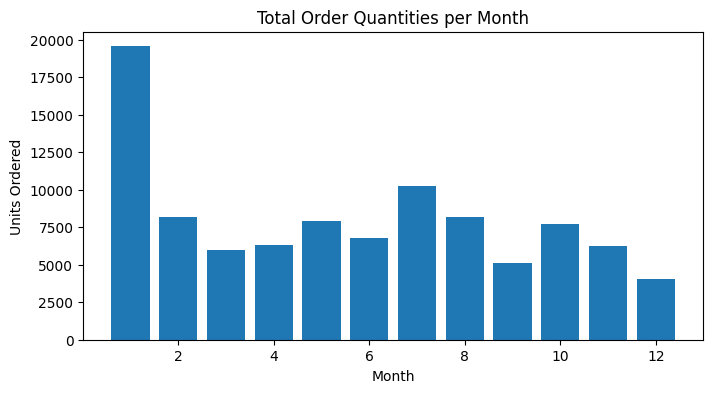

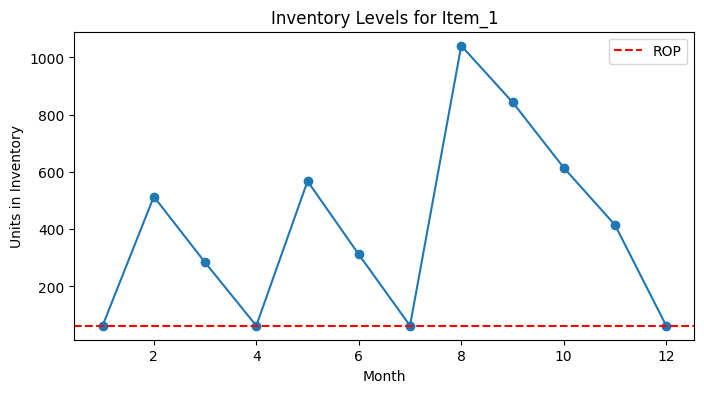

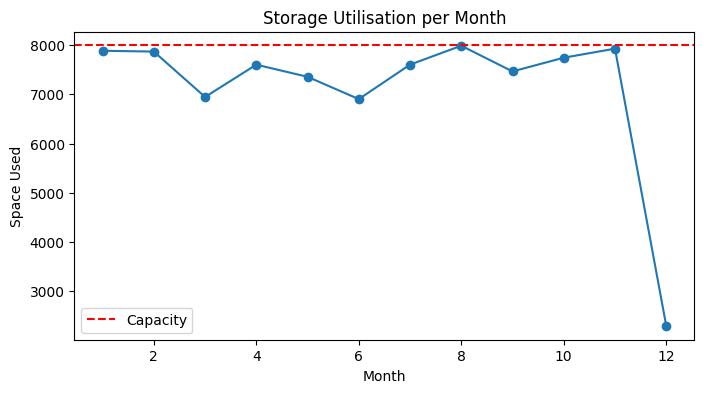


=== Reorder Alerts ===


,item_id,item_name,current_stock,ROP
0,10,Item_11,81,90
1,17,Item_18,89,91
2,20,Item_21,89,90
3,24,Item_25,30,35


In [10]:
import matplotlib.pyplot as plt

# 1) Show status & cost summary
print("\n=== MIP Solver Status ===")
print(pulp.LpStatus[prob.status])

print("\n=== Cost Breakdown ===")
display(obj_df.style.format("{:,.2f}"))

# 2) Show first few rows of orders and inventories
print("\n=== Orders (first 12 rows) ===")
display(orders_df.head(12))

print("\n=== Inventories (first 12 rows) ===")
display(inv_df.head(12))

# 3) Plot orders per month (all items)
orders_monthly = orders_df.groupby('period')['order_qty'].sum().reset_index()
plt.figure(figsize=(8,4))
plt.bar(orders_monthly['period'], orders_monthly['order_qty'])
plt.title("Total Order Quantities per Month")
plt.xlabel("Month")
plt.ylabel("Units Ordered")
plt.show()

# 4) Plot inventory trend for a sample item
sample_item = items.iloc[0]['item_id']
inv_sample = inv_df[inv_df['item_id'] == sample_item]
plt.figure(figsize=(8,4))
plt.plot(inv_sample['period'], inv_sample['end_inventory'], marker='o')
plt.axhline(y=SS[sample_item], color='r', linestyle='--', label="ROP")
plt.title(f"Inventory Levels for {items.iloc[0]['item_name']}")
plt.xlabel("Month")
plt.ylabel("Units in Inventory")
plt.legend()
plt.show()

# 5) Storage utilisation per month
storage_use = inv_df.merge(items[['item_id','storage_space_required']], on='item_id')
storage_use['space_used'] = storage_use['end_inventory'] * storage_use['storage_space_required']
storage_monthly = storage_use.groupby('period')['space_used'].sum().reset_index()
plt.figure(figsize=(8,4))
plt.plot(storage_monthly['period'], storage_monthly['space_used'], marker='o')
plt.axhline(y=TOTAL_STORAGE_CAPACITY, color='r', linestyle='--', label="Capacity")
plt.title("Storage Utilisation per Month")
plt.xlabel("Month")
plt.ylabel("Space Used")
plt.legend()
plt.show()

# 6) Reorder alerts
print("\n=== Reorder Alerts ===")
if reorder_df.empty:
    print("No items below ROP at current stock.")
else:
    display(reorder_df)
